# Level 2 1<sup>st</sup> Competition

1조 competition 자료

In [1]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from gensim.models.fasttext import FastText as FT_gensim

import nltk
from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta

from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from tensorflow_addons.optimizers import AdamW

# 참고 자료 및 출처

데이터셋 논문: https://arxiv.org/pdf/1811.04231.pdf <br>
GitHub: https://github.com/warnikchow/3i4k

Pretrained Data Citation

@article{cho2018real, <br>
	title={Real-time Automatic Word Segmentation for User-generated Text}, <br>
	author={Cho, Won Ik and Cheon, Sung Jun and Kang, Woo Hyun and Kim, Ji Won and Kim, Nam Soo}, <br>
	journal={arXiv preprint arXiv:1810.13113}, <br>
	year={2018} <br>
}

Dataset, Guideline Citation

@article{cho2018speech, <br>
	title={Speech Intention Understanding in a Head-final Language: A Disambiguation Utilizing Intonation-dependency}, <br>
	author={Cho, Won Ik and Lee, Hyeon Seung and Yoon, Ji Won and Kim, Seok Min and Kim, Nam Soo}, <br>
	journal={arXiv preprint arXiv:1811.04231}, <br>
	year={2018} <br>
}

# Preparing Dataset

In [2]:
# !wget https://raw.githubusercontent.com/warnikchow/3i4k/master/data/train_val_test/fci_train_val.txt
# !wget https://raw.githubusercontent.com/warnikchow/3i4k/master/data/train_val_test/fci_test.txt

In [3]:
def read_data(filename):

    with open(filename, "r", encoding="UTF8") as f:
        data = [line.split("\t") for line in f.read().splitlines()]

    return data

In [4]:
train_data = read_data("fci_train_val.txt")
X_train_data = [t[1] for t in train_data]
y_train_data = [int(t[0]) for t in train_data]

test_data = read_data("fci_test.txt")
X_test_data = [t[1] for t in test_data]
y_test_data = [int(t[0]) for t in test_data]

In [5]:
print(len(X_train_data))
print(len(y_train_data))
print(len(X_test_data))
print(len(y_test_data))

print(X_train_data[:10])

55134
55134
6121
6121
['만화', '이치가', '약', '그사이', '짜긴', '혜택', '지출', '어젯밤', '승진', '꼬마']


## Weight Correction

> 마땅한 방법이 떠오르지 않아서 하드코딩 했는데, 더 나은 방법이 있을지?

In [6]:
zero_c = 0
one_c = 0
two_c = 0
three_c = 0
four_c = 0
five_c = 0
six_c = 0

for number in y_train_data:

    if number == 0:
         zero_c += 1
    elif number == 1:
        one_c += 1
    elif number == 2:
        two_c += 1
    elif number == 3:
        three_c += 1
    elif number == 4:
        four_c += 1
    elif number == 5:
        five_c += 1
    elif number == 6:
        six_c += 1
    else:
        raise ValueError

weight_list = [zero_c, one_c, two_c, three_c, four_c, five_c, six_c]

print(weight_list)
print(zero_c + one_c + two_c + three_c + four_c + five_c + six_c)

[5409, 16470, 16083, 11672, 1571, 979, 2950]
55134


In [8]:
class_weight = {}

for i in range(len(weight_list)):
    
    foo = len(X_train_data) / ((len(weight_list)) * weight_list[i]) ** 1.0625
    
    print((weight_list[i]))
    print(foo)

    if foo > 1:
        class_weight[i] = foo
    else:
        class_weight[i] = 1.0

print(class_weight)

5409
0.753470132537547
16470
0.23081598658927413
16083
0.23672156921527
11672
0.3327828797282365
1571
2.8026291694923424
979
4.63229516460494
2950
1.4348844939348124
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 2.8026291694923424, 5: 4.63229516460494, 6: 1.4348844939348124}


# Pretrained Data

아래의 사이트에서 pretrained된 100차원 fastText data를 제공하고 있습니다. 원하실 경우 사용하셔도 좋습니다.

https://drive.google.com/file/d/1jHbjOcnaLourFzNuP47yGQVhBTq6Wgor/view

* Download this and unzip THE .BIN FILE in the NEW FOLDER named 'vectors'.
* This can be replaced with whatever model the user employs, but it requires an additional training.

> Preprocessing이 모두 끝난 뒤에 불러오겠습니다.

# Preprocessing

## Tokenization

In [9]:
# 위키독스의 불용어 목록

stopwords_foo = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
# https://bab2min.tistory.com/544

df = pd.read_csv("stopword_data.txt", sep='\t', names=["word", "pos", "ratio"])
stopwords = df["word"].tolist()
stopwords.extend(stopwords_foo)
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


In [11]:
pos_tagger = Okt()

def tokenizing(doc):
    x = [t[0] for t in pos_tagger.pos(doc) if not t[0] in stopwords]
    
    return ' '.join(x)

X_train_token = [tokenizing(row) for row in X_train_data]
X_test_token  = [tokenizing(row) for row in X_test_data]

### nltk tokenizer로
X_train_token_splitted = [nltk.word_tokenize(row) for row in X_train_token]
X_test_token_splitted  = [nltk.word_tokenize(row) for row in X_test_token]

In [12]:
print(X_train_token[20000:20010])
print(X_train_token_splitted[20000:20010])

['오늘 저녁 무슨 약속 있지', '현관문 닫혔는지 확인 해줘', '콜라 마요네즈 섞으면', '보일러 껐니', '청담동 가려면 뭐 타고 가야 하냐', '서울 근교 놀이 공원 어디 냐', '이번 달 있는 공휴일 얼마나 되니', '이번 토요일 오전 일곱시 도로 안개 끼니', '가스 불 끄고 나왔는지 확인 부탁 할게', '뜨개질 관련 메일 왔니']
[['오늘', '저녁', '무슨', '약속', '있지'], ['현관문', '닫혔는지', '확인', '해줘'], ['콜라', '마요네즈', '섞으면'], ['보일러', '껐니'], ['청담동', '가려면', '뭐', '타고', '가야', '하냐'], ['서울', '근교', '놀이', '공원', '어디', '냐'], ['이번', '달', '있는', '공휴일', '얼마나', '되니'], ['이번', '토요일', '오전', '일곱시', '도로', '안개', '끼니'], ['가스', '불', '끄고', '나왔는지', '확인', '부탁', '할게'], ['뜨개질', '관련', '메일', '왔니']]


## 정수 인코딩

In [13]:
tokenizer = Tokenizer(oov_token = 'OOV')
tokenizer.fit_on_texts(X_train_token_splitted)

In [14]:
print(len(tokenizer.word_index))
#print(tokenizer.word_index)

31358


In [15]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31358
등장 빈도가 1번 이하인 희귀 단어의 수: 16078
단어 집합에서 희귀 단어의 비율: 51.272402576694944
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.278328583997584


In [16]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 15282


In [17]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train_token_splitted)
X_train = tokenizer.texts_to_sequences(X_train_token_splitted)
X_test = tokenizer.texts_to_sequences(X_test_token_splitted)

In [18]:
print(X_train[:3])
print(X_test[:3])

[[4600], [10534], [361]]
[[1], [448], []]


## Padding

문장의 최대 길이 : 36
문장의 평균 길이 : 5.5247941379185255


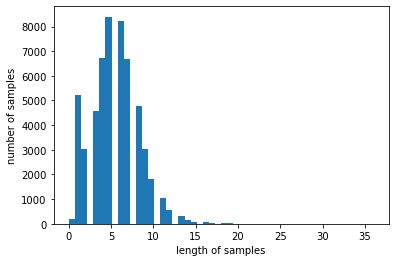

In [19]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
max_len = 22   # 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 22 이하인 샘플의 비율: 99.90568433271665


In [22]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [23]:
print(X_train[:3])
print(X_test[:3])
print(y_train[:3])
print(y_test[:3])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0  4600]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0 10534]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0   361]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 448]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(46863, 22)
(46863, 7)
(8271, 22)
(8271, 7)
(6121, 22)
(6121, 7)


# Pretrained Embedding Data

In [25]:
loaded_model = FT_gensim.load_fasttext_format('model_drama.bin') #pretrained data 로드

In [26]:
print(loaded_model)

FastText(vocab=160043, size=100, alpha=0.025)


In [27]:
print("안녕" in loaded_model.wv.vocab)
print(loaded_model.most_similar("안녕"))
print(loaded_model["안녕"])

True


/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('왔으니깐', 0.7077229619026184), ('하였더니', 0.689039409160614), ('재석이', 0.665482759475708), ('해주시기', 0.6634321808815002), ('고생시켜서', 0.6615829467773438), ('이호진의', 0.6615034341812134), ('그곳으로', 0.6586490869522095), ('병석이', 0.6558609008789062), ('희재', 0.6556533575057983), ('무브', 0.6513947248458862)]
[-0.20837323  0.21626383  0.0054911   0.07921323  0.203135    0.03575059
 -0.12396514  0.174983    0.2385913   0.20969039 -0.06152691 -0.05342709
  0.00817227  0.0137452   0.25210565  0.14207946 -0.0069862   0.07155829
 -0.11726188 -0.01571709 -0.18182424 -0.04145883  0.06458063 -0.13819216
 -0.04949455  0.10642069  0.10609311 -0.05291022 -0.25471207 -0.06118836
  0.07871876 -0.02403206  0.05075282 -0.13062136 -0.03300982  0.00239827
 -0.20694333 -0.09797629 -0.04896694  0.1861868  -0.03632177 -0.01879727
 -0.05107179  0.07315976 -0.06730977 -0.17247403 -0.04448244  0.03694947
 -0.1605727  -0.15880612  0.09569672  0.31981894 -0.03940499 -0.02544998
 -0.03745533  0.06832626 -0.00944789 -0.17063852 

/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
embedding_matrix = np.zeros((total_cnt + 2, 100))

for word, i in tokenizer.word_index.items():
    
    if word in loaded_model:
        embedding_vector = loaded_model[word]
        
    else:
        continue
        
    embedding_matrix[i] = embedding_vector

/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [29]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0201662   0.0789165   0.00863309 ... -0.09077461 -0.07218648
  -0.11439495]
 [ 0.19867121 -0.08441713 -0.08691589 ... -0.07481183  0.09989324
  -0.41806331]
 ...
 [ 0.00954878  0.0017603   0.00534863 ...  0.01200104 -0.04521481
   0.02055699]
 [ 0.01491402  0.01213227 -0.00414175 ... -0.06965395  0.01472734
  -0.08061473]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [30]:
print("단어 안녕의 정수 인덱스 :", tokenizer.word_index["안녕"])

단어 안녕의 정수 인덱스 : 4605


In [31]:
print(embedding_matrix[4605])

[-0.20837323  0.21626383  0.0054911   0.07921323  0.203135    0.03575059
 -0.12396514  0.17498299  0.2385913   0.20969039 -0.06152691 -0.05342709
  0.00817227  0.0137452   0.25210565  0.14207946 -0.0069862   0.07155829
 -0.11726188 -0.01571709 -0.18182424 -0.04145883  0.06458063 -0.13819216
 -0.04949455  0.10642069  0.10609311 -0.05291022 -0.25471207 -0.06118836
  0.07871876 -0.02403206  0.05075282 -0.13062136 -0.03300982  0.00239827
 -0.20694333 -0.09797629 -0.04896694  0.18618681 -0.03632177 -0.01879727
 -0.05107179  0.07315976 -0.06730977 -0.17247403 -0.04448244  0.03694947
 -0.16057269 -0.15880612  0.09569672  0.31981894 -0.03940499 -0.02544998
 -0.03745533  0.06832626 -0.00944789 -0.17063852 -0.06772653 -0.13011421
 -0.06931078  0.03487949 -0.21680628 -0.01007261 -0.04196937  0.00295484
  0.24279918  0.24640991 -0.09263007  0.12259059 -0.01626277 -0.02440865
 -0.05974907  0.02232739 -0.03351026  0.33445835  0.23039845 -0.02479115
  0.07557323 -0.1628316   0.26275724 -0.03214483 -0

In [32]:
print(loaded_model["안녕"])

[-0.20837323  0.21626383  0.0054911   0.07921323  0.203135    0.03575059
 -0.12396514  0.174983    0.2385913   0.20969039 -0.06152691 -0.05342709
  0.00817227  0.0137452   0.25210565  0.14207946 -0.0069862   0.07155829
 -0.11726188 -0.01571709 -0.18182424 -0.04145883  0.06458063 -0.13819216
 -0.04949455  0.10642069  0.10609311 -0.05291022 -0.25471207 -0.06118836
  0.07871876 -0.02403206  0.05075282 -0.13062136 -0.03300982  0.00239827
 -0.20694333 -0.09797629 -0.04896694  0.1861868  -0.03632177 -0.01879727
 -0.05107179  0.07315976 -0.06730977 -0.17247403 -0.04448244  0.03694947
 -0.1605727  -0.15880612  0.09569672  0.31981894 -0.03940499 -0.02544998
 -0.03745533  0.06832626 -0.00944789 -0.17063852 -0.06772653 -0.13011421
 -0.06931078  0.03487949 -0.21680628 -0.01007261 -0.04196937  0.00295484
  0.24279918  0.24640991 -0.09263007  0.12259059 -0.01626277 -0.02440865
 -0.05974907  0.02232739 -0.03351026  0.33445835  0.23039845 -0.02479115
  0.07557323 -0.1628316   0.26275724 -0.03214483 -0

/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


# Modeling 1

In [33]:
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, Conv1D, BatchNormalization, Activation

def swish(x):
    return x * tf.nn.sigmoid(x)

In [34]:
model = Sequential()

model.add(Embedding(total_cnt + 2 , 100, weights=[embedding_matrix], embeddings_initializer="glorot_normal", trainable=True))
model.add(Dropout(0.5))
model.add(Conv1D(256, 1, padding="valid", strides=1, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Conv1D(128, 1, padding="valid", strides=1, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(AveragePooling1D(1))
model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_initializer="glorot_normal")))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_initializer="glorot_normal")))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, kernel_initializer="glorot_normal")))
model.add(Dense(7, activation="softmax"))

In [35]:
lr_Cosine_Decay = CosineDecayRestarts(
    initial_learning_rate=(5e-4), first_decay_steps=184,   # 87
    t_mul=2, m_mul=0.80, alpha=0.0, name=None   #0.75
)

In [36]:
f1 = F1Score(num_classes=7, name="F1")
weighted_f1 = F1Score(num_classes=7, average="weighted", name="Weighted_F1")

mc = ModelCheckpoint("best_model.h5", monitor="val_acc", mode="max", verbose=1, save_best_only=True)

model.compile(optimizer=AdamW(lr_Cosine_Decay),
              loss="categorical_crossentropy", metrics=["acc", f1, weighted_f1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3136000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         25856     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         5

In [37]:
history = model.fit(X_train, y_train, epochs=31, validation_data=(X_val, y_val), callbacks=[mc], batch_size=256, class_weight=class_weight)

Epoch 1/31
184/184 [==============================] - ETA: 0s - loss: 1.2036 - acc: 0.6777 - F1: 0.5238 - Weighted_F1: 0.6681
Epoch 00001: val_acc improved from -inf to 0.44807, saving model to best_model.h5
184/184 [==============================] - 10s 57ms/step - loss: 1.2036 - acc: 0.6777 - F1: 0.5238 - Weighted_F1: 0.6681 - val_loss: 1.6769 - val_acc: 0.4481 - val_F1: 0.2602 - val_Weighted_F1: 0.4127
Epoch 2/31
183/184 [============================>.] - ETA: 0s - loss: 0.7470 - acc: 0.8122 - F1: 0.6950 - Weighted_F1: 0.8154
Epoch 00002: val_acc improved from 0.44807 to 0.76315, saving model to best_model.h5
184/184 [==============================] - 7s 36ms/step - loss: 0.7470 - acc: 0.8122 - F1: 0.6950 - Weighted_F1: 0.8154 - val_loss: 0.7269 - val_acc: 0.7631 - val_F1: 0.6304 - val_Weighted_F1: 0.7619
Epoch 3/31
183/184 [============================>.] - ETA: 0s - loss: 0.5764 - acc: 0.8542 - F1: 0.7595 - Weighted_F1: 0.8569
Epoch 00003: val_acc improved from 0.76315 to 0.84597,

In [38]:
model.evaluate(X_test, y_test)

192/192 [==============================] - 2s 8ms/step - loss: 0.7633 - acc: 0.8423 - F1: 0.7528 - Weighted_F1: 0.8431


[0.7632507681846619,
 0.8423460125923157,
 array([0.9168766 , 0.82543164, 0.91525424, 0.8528718 , 0.55813956,
        0.59322035, 0.6079295 ], dtype=float32),
 0.8430989384651184]

In [39]:
model = load_model("best_model.h5")

In [40]:
model.evaluate(X_test, y_test)

192/192 [==============================] - 2s 10ms/step - loss: 0.4909 - acc: 0.8538 - F1: 0.7591 - Weighted_F1: 0.8515


[0.49087944626808167,
 0.853782057762146,
 array([0.91390735, 0.84669995, 0.91860145, 0.85658157, 0.56105614,
        0.6018519 , 0.6148649 ], dtype=float32),
 0.851534366607666]